In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
hsankesara_flickr_image_dataset_path = kagglehub.dataset_download('hsankesara/flickr-image-dataset')

print('Data source import complete.')

# Explore & Visualize the DataSet

In [ ]:
import pandas as pd
import os
import time
from tqdm import tqdm
import re

# for Explore & Visualize
from PIL import Image
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
from nltk import pos_tag
from wordcloud import WordCloud

# for preprocessing data
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from nltk.tokenize import word_tokenize

# for building the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, add, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import pickle

2024-10-21 07:28:45.757961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 07:28:45.758050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 07:28:45.887637: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
csv_path = r"/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
df = pd.read_table(csv_path, sep="|")
df.head(9)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .


In [ ]:
new_columns = {
    " comment_number" : "comment_number",
    " comment" : "comment"
}
df = df.rename(columns=new_columns)

In [ ]:
grouped_data = df.groupby('image_name')['comment'].apply(lambda group: group.values.tolist()).reset_index(name='comments')

In [ ]:
grouped_data

,image_name,comments
0,1000092795.jpg,[ Two young guys with shaggy hair look at thei...
1,10002456.jpg,[ Several men in hard hats are operating a gia...
2,1000268201.jpg,[ A child in a pink dress is climbing up a set...
3,1000344755.jpg,[ Someone in a blue shirt and hat is standing ...
4,1000366164.jpg,"[ Two men , one in a gray shirt , one in a bla..."
...,...,...
31778,997338199.jpg,"[ Woman writing on a pad in room with gold , d..."
31779,997722733.jpg,[ A person in a red shirt climbing up a rock f...
31780,997876722.jpg,[ Two male construction workers are working on...
31781,99804383.jpg,[ An older busker in glasses plays an Eastern ...


In [ ]:
# Prepare image_paths, and descriptions for the visualize_samples function
image_paths = ['/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/' + image_name for image_name in grouped_data['image_name']]
descriptions = grouped_data['comments']

In [ ]:
def visualize_samples(image_paths, descriptions, num_samples=7):

    sampled_indices = random.sample(range(len(image_paths)), min(num_samples, len(image_paths)))
    sampled_image_paths = [image_paths[i] for i in sampled_indices]
    sampled_descriptions = [descriptions[i] for i in sampled_indices]

    fig, axs = plt.subplots(num_samples, 2, figsize=(15, 20))

    for i in range(num_samples):
        img_path = sampled_image_paths[i]
        description_list = [desc.split(' ', 1)[1] for desc in sampled_descriptions[i]]

        # Load and display image
        img = mpimg.imread(img_path)
        axs[i, 0].imshow(img)
        axs[i, 0].axis('off')

        # Display multiple descriptions as text
        axs[i, 1].text(0.5, 0.5, '\n'.join(description_list), fontsize=10, va='center', ha='center', wrap=True)
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

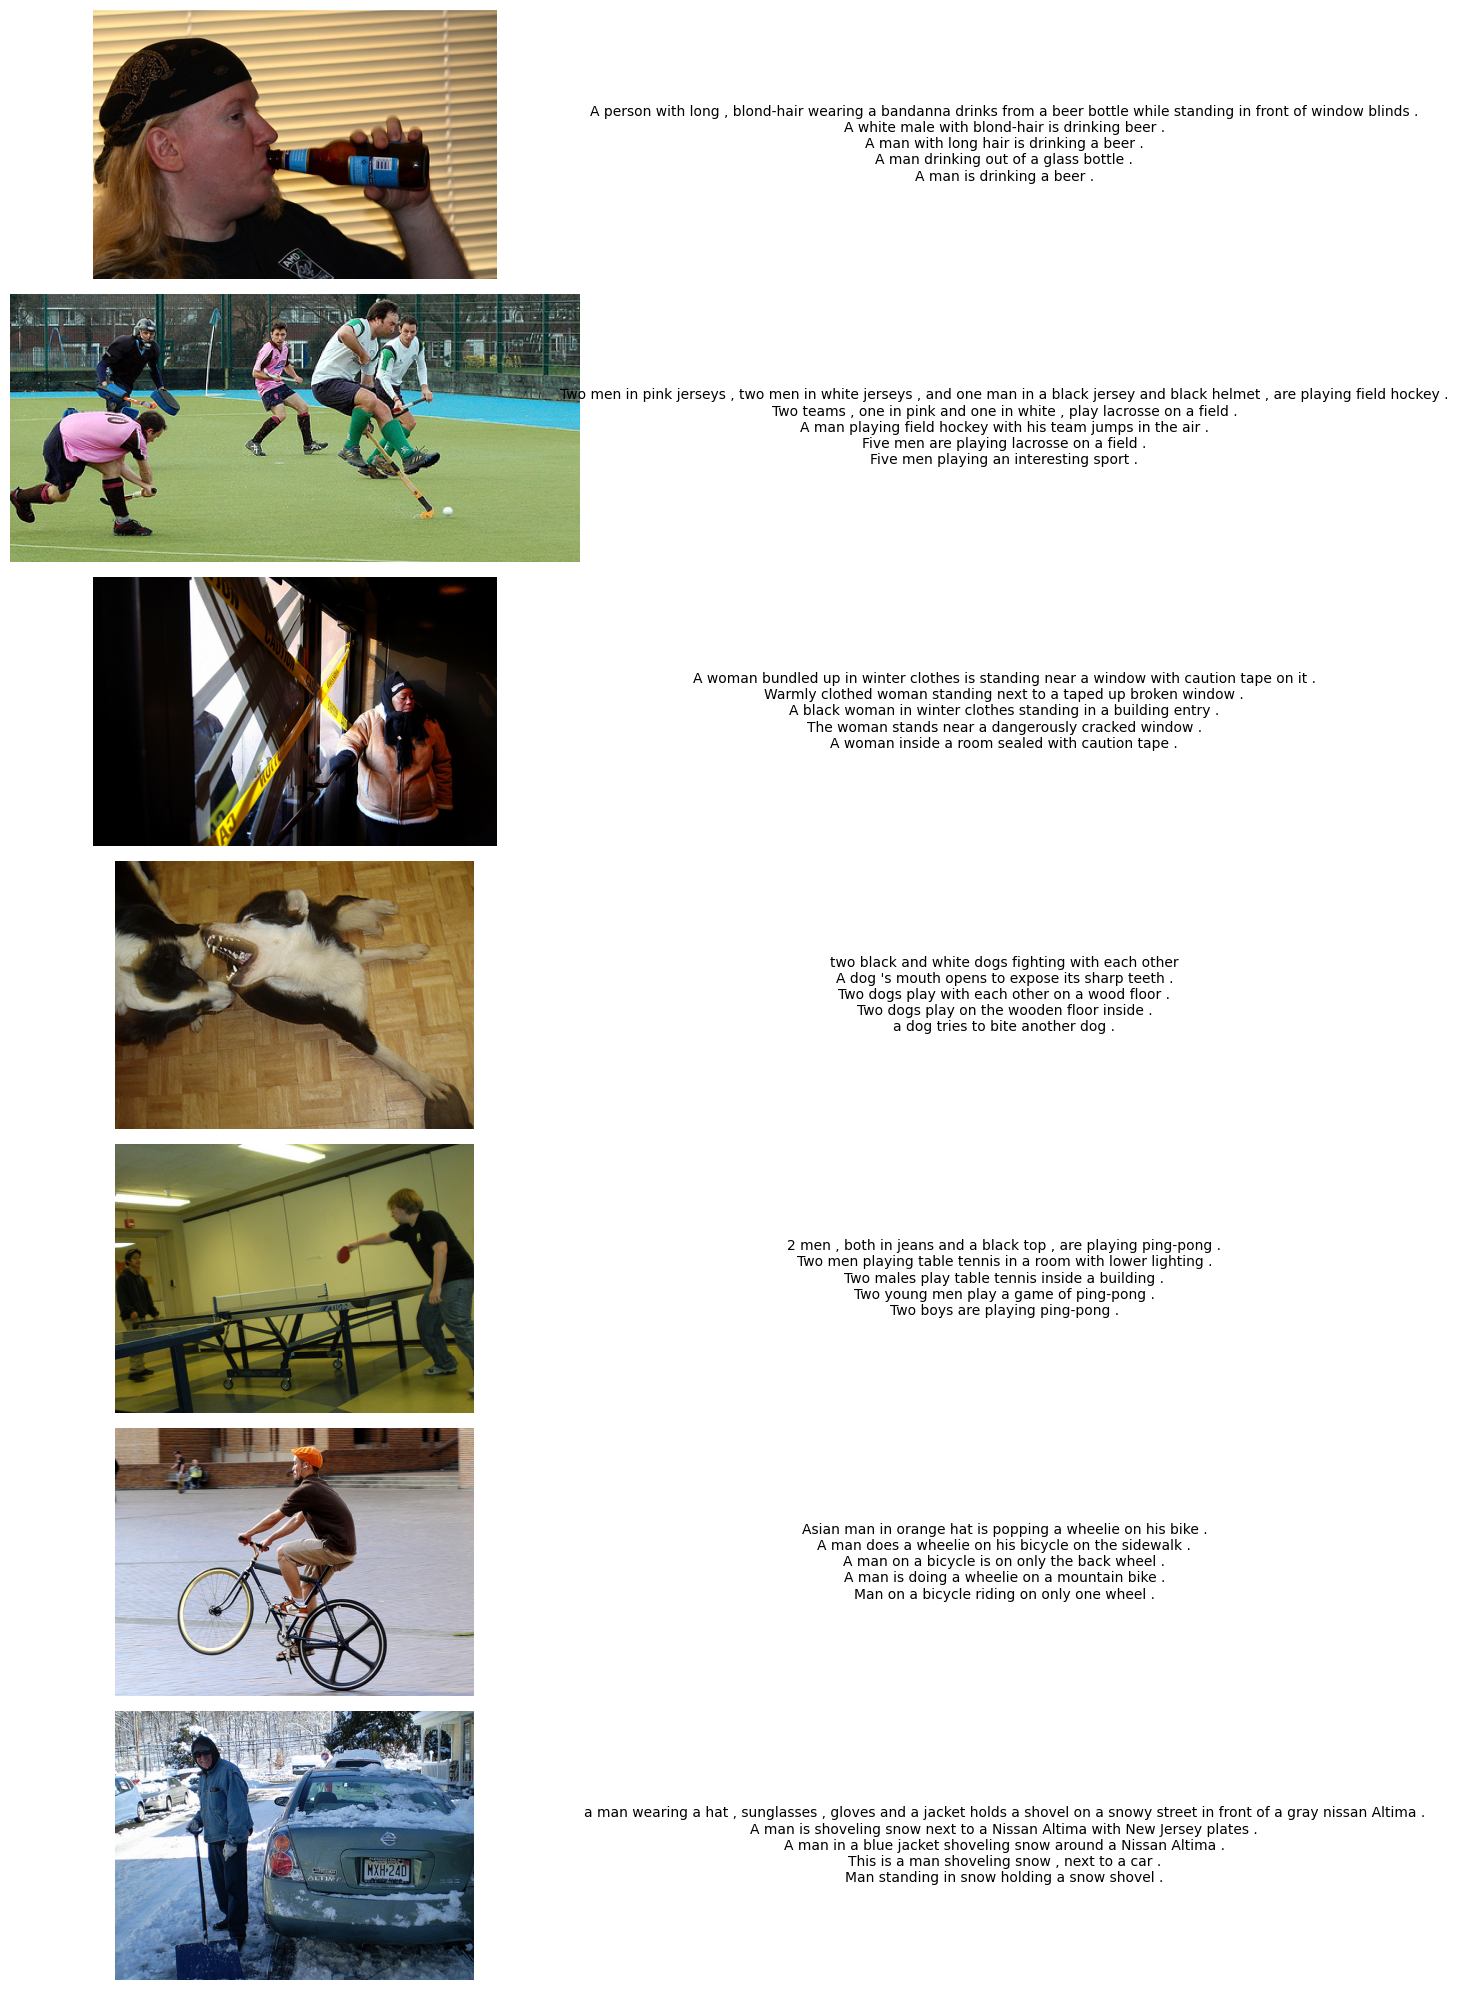

In [ ]:
visualize_samples(image_paths, descriptions)

# exploratory data analysis (EDA)

### <span style="font-weight: bold; color: #007bff;">Basic Statistics:</apan>

Get basic statistics about the dataset, such as the number of unique images, comments, etc.

In [ ]:
unique_images = df['image_name'].nunique()
unique_comments = df['comment'].nunique()
total_records = len(df)

print(f"Number of unique images: {unique_images}")
print(f"Number of unique comments: {unique_comments}")
print(f"Total number of records: {total_records}")

Number of unique images: 31783
Number of unique comments: 158438
Total number of records: 158915


### <span style="font-weight: bold; color: #007bff;">Distribution of Comments per Image:</span>

Visualize the distribution of comments per image to understand how many comments are typically associated with each image.

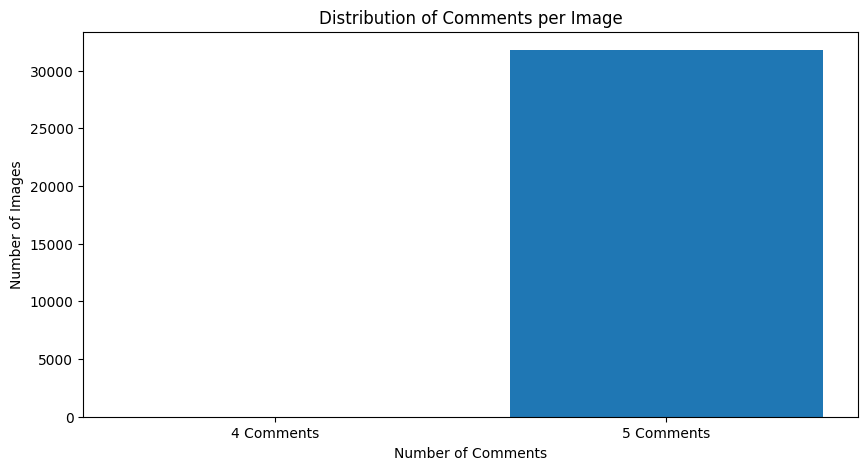

In [ ]:
comments_per_image = df.groupby('image_name')['comment'].count()

images_with_4_comments = comments_per_image[comments_per_image == 4]
images_with_5_comments = comments_per_image[comments_per_image == 5]

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar([3.5, 4.5], [len(images_with_4_comments), len(images_with_5_comments)], tick_label=['4 Comments', '5 Comments'])
plt.xlabel('Number of Comments')
plt.ylabel('Number of Images')
plt.title('Distribution of Comments per Image')
plt.show()

### <span style="font-weight: bold; color: #007bff;">Word Cloud:</span>

Generate a word cloud to visualize the most frequent words in the comments.

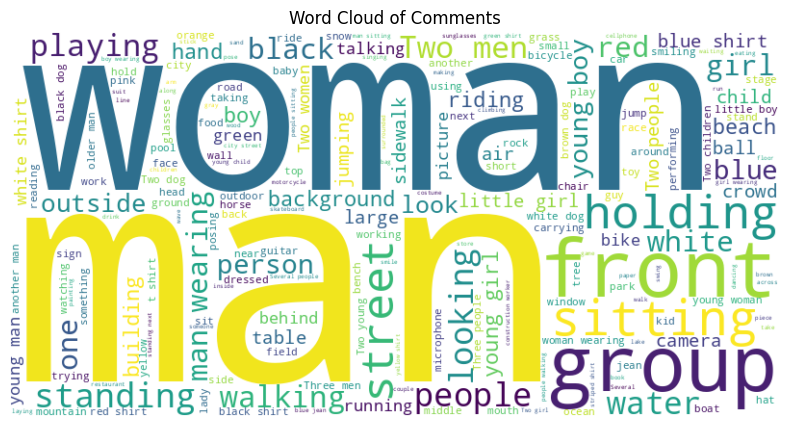

In [ ]:
all_comments_text = ' '.join(df['comment'].fillna(''))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

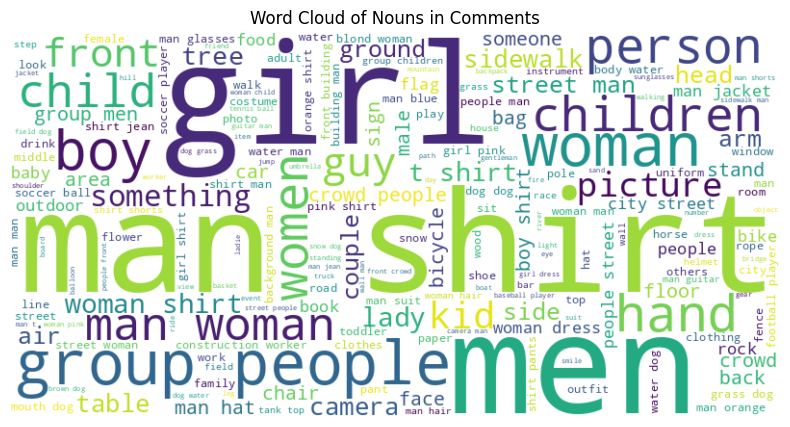

In [ ]:
df['pos_tags'] = df['comment'].fillna("").apply(lambda x: pos_tag(word_tokenize(x.lower())))

nouns = [word[0] for tags in df['pos_tags'] for word in tags if word[1].startswith('NN')]

wordcloud_nouns = WordCloud(width=800, height=400, background_color='white').generate(' '.join(nouns))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_nouns, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Nouns in Comments')
plt.show()

### <span style="font-weight: bold; color: #007bff;">Caption Length Distribution:</span>

Analyze the distribution of caption lengths to understand the range of caption lengths in the dataset.

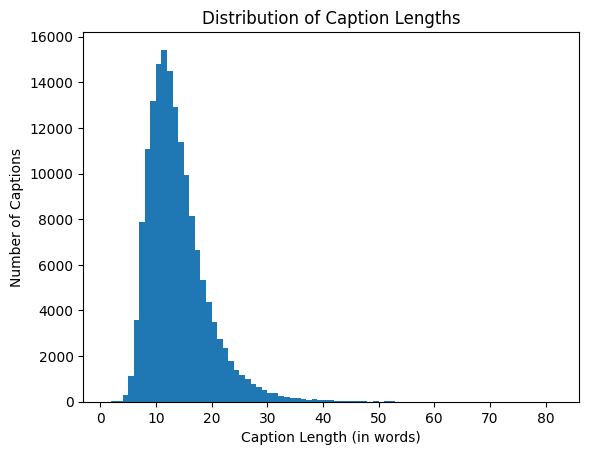

In [ ]:
# Caption length distribution
df['caption_length'] = df['comment'].fillna('').apply(lambda x: len(x.split()))
plt.hist(df['caption_length'], bins=range(1, max(df['caption_length']) + 1))
plt.xlabel('Caption Length (in words)')
plt.ylabel('Number of Captions')
plt.title('Distribution of Caption Lengths')
plt.show()


# Data Pre-processing
### <span style="font-weight: bold; color: #007bff;">Deal with the nan value:</span>
There is only one image that contains four descriptions instead of five, <span style="font-weight: bold; color: red;">I will not consider it. </span>

In [ ]:
df.isna().sum()

image_name        0
comment_number    0
comment           1
pos_tags          0
caption_length    0
dtype: int64

In [ ]:
target_column = 'comment'
nan_indices = df[df[target_column].isna()]
nan_indices

,image_name,comment_number,comment,pos_tags,caption_length
19999,2199200615.jpg,4 A dog runs across the grass .,NaN,[],0


In [ ]:
image_to_delete = '2199200615.jpg'
file_name_column = 'image_name'


index_to_delete = df[df[file_name_column] == image_to_delete].index
index_to_delete

Index([19995, 19996, 19997, 19998, 19999], dtype='int64')

In [ ]:
df = df.drop(index_to_delete, axis=0)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.isna().sum()

image_name        0
comment_number    0
comment           0
pos_tags          0
caption_length    0
dtype: int64

In [ ]:
# Extract images with 5 comments
images_with_5_comments = df.groupby('image_name').filter(lambda group: len(group) == 5)['image_name'].unique()

In [ ]:
sample = '997338199.jpg'
('2199200615.jpg' in images_with_5_comments, sample in images_with_5_comments)

(False, True)

In [ ]:
images_with_5_comments[:10]

array(['1000092795.jpg', '10002456.jpg', '1000268201.jpg',
       '1000344755.jpg', '1000366164.jpg', '1000523639.jpg',
       '1000919630.jpg', '10010052.jpg', '1001465944.jpg',
       '1001545525.jpg'], dtype=object)

In [ ]:
df

,image_name,comment_number,comment,pos_tags,caption_length
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,"[(two, CD), (young, JJ), (guys, NNS), (with, I...",17
1,1000092795.jpg,1,"Two young , White males are outside near many...","[(two, CD), (young, JJ), (,, ,), (white, JJ), ...",11
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,"[(two, CD), (men, NNS), (in, IN), (green, JJ),...",11
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,"[(a, DT), (man, NN), (in, IN), (a, DT), (blue,...",11
4,1000092795.jpg,4,Two friends enjoy time spent together .,"[(two, CD), (friends, NNS), (enjoy, JJ), (time...",7
...,...,...,...,...,...
158905,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...,"[(a, DT), (man, NN), (in, IN), (shorts, NNS), ...",25
158906,998845445.jpg,1,"A young man hanging over the side of a boat ,...","[(a, DT), (young, JJ), (man, NN), (hanging, VB...",25
158907,998845445.jpg,2,A man is leaning off of the side of a blue an...,"[(a, DT), (man, NN), (is, VBZ), (leaning, VBG)...",23
158908,998845445.jpg,3,"A man riding a small boat in a harbor , with ...","[(a, DT), (man, NN), (riding, VBG), (a, DT), (...",18


___

### Extract Image Features (VGG16)

In [ ]:
selected_df = grouped_data[grouped_data['image_name'].isin(images_with_5_comments[:10000])]
selected_df

,image_name,comments
0,1000092795.jpg,[ Two young guys with shaggy hair look at thei...
1,10002456.jpg,[ Several men in hard hats are operating a gia...
2,1000268201.jpg,[ A child in a pink dress is climbing up a set...
3,1000344755.jpg,[ Someone in a blue shirt and hat is standing ...
4,1000366164.jpg,"[ Two men , one in a gray shirt , one in a bla..."
...,...,...
9996,2952141476.jpg,[ A person is out in the water at the beach wh...
9997,295229746.jpg,[ A person in an apron is selling many differe...
9998,2952320230.jpg,[ The woman is dressed in all white swinging a...
9999,295258727.jpg,[ Two distant black dogs running across grass ...


In [ ]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 3s 0us/step


In [ ]:
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [ ]:
features_save_path = "/kaggle/working/features_dict.pkl"

In [ ]:
with open(features_save_path, 'wb') as file: # Save
    pickle.dump(feature_dict, file)

NameError: name 'feature_dict' is not defined

In [ ]:
with open(features_save_path, 'rb') as file: # Load
    loaded_features_dict = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/features_dict.pkl'

# Text Processing

In [ ]:
def preprocessing_text(data):
    data['comments'] = data['comments'].apply(lambda x: [comment.lower() for comment in x])
    data['comments'] = data['comments'].apply(lambda x: [' '.join(re.sub(r'[^a-zA-Z\s]', ' ', word) for word in comment.split() if len(word) > 1) for comment in x])
    data['comments'] = data['comments'].apply(lambda x: ['startseq ' + comment + ' endseq' for comment in x])
    return data

In [ ]:
data = preprocessing_text(selected_df)

In [ ]:
data.comments.tolist()[-1]

In [ ]:
all_captions = []
for captions in data.comments:
    for caption in captions:
        all_captions.append(caption)

In [ ]:
all_captions[:5]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

In [ ]:
image_ids = list(loaded_features_dict.keys())
split = int(len(image_ids) * 0.97)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
def custom_data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    image_inputs, sequence_inputs, output_labels = [], [], []
    while True:
        for key in data_keys:
            captions_list = mapping[key]
            for caption in captions_list:
                sequence = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(sequence)):
                    input_seq, output_seq = sequence[:i], sequence[i]
                    input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
                    image_inputs.append(features[key][0])
                    sequence_inputs.append(input_seq)
                    output_labels.append(output_seq)

            if len(image_inputs) >= batch_size:
                yield [np.array(image_inputs), np.array(sequence_inputs)], np.array(output_labels)
                image_inputs, sequence_inputs, output_labels = [], [], []


# Building & Train the model

In [ ]:
# Image feature layers
image_input = Input(shape=(4096,))
image_dropout = Dropout(0.4)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Sequence feature layers
sequence_input = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 256, mask_zero=True)(sequence_input)
sequence_dropout = Dropout(0.4)(embedding_layer)
lstm_layer = LSTM(256)(sequence_dropout)

In [ ]:
# Decoder model
merged_features = add([image_dense, lstm_layer])
decoder_dense1 = Dense(256, activation='relu')(merged_features)
output_layer = Dense(vocab_size, activation='softmax')(decoder_dense1)

In [ ]:
# Combine the image and sequence inputs into the model
custom_model = Model(inputs=[image_input, sequence_input], outputs=output_layer)

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
custom_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Plot the model architecture
plot_model(custom_model)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

In [ ]:
mapping = dict(zip(loaded_features_dict.keys(), data.comments.values.tolist()))

In [ ]:
# for i in range(epochs):
#     generator = custom_data_generator(train, mapping, loaded_features_dict, tokenizer, max_length, vocab_size, batch_size)
#     custom_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
custom_model.save('/kaggle/working/model.h5') # Save

In [ ]:
custom_model = load_model('/kaggle/working/model.h5') # Load

# Predict

In [ ]:
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer, None)

In [ ]:
def generate_caption(model, image, tokenizer, max_length):
    generated_caption = 'startseq'
    initial_sequence = tokenizer.texts_to_sequences([generated_caption])[0]

    for _ in range(max_length):

        padded_sequence = pad_sequences([initial_sequence], max_length)

        predictions = model.predict([image, padded_sequence], verbose=0)
        predicted_index = np.argmax(predictions)

        predicted_word = idx_to_word(predicted_index, tokenizer)
        if predicted_word is None:
            break

        generated_caption += " " + predicted_word

        if predicted_word == 'endseq':
            break
    return generated_caption


In [ ]:
def predict_caption(image_name, max_length):
    # load the image

    image_id = image_name.split('.')[0]
    img_path = f"/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/{image_name}"
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('Actual'.center(90, "-"))
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = generate_caption(custom_model, loaded_features_dict[image_id], tokenizer, max_length)
    print('Predicted'.center(90, "-"))
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')

In [ ]:
predict_caption("1011572216.jpg", 30)